Learning the distribution of the MNIST digits and generating from it using Gaussian Mixtures.\
The density corresponding to possible digit combinations should be high. In other words, generating from this distribution can be thought of as collecting more training samples, i.e. more ways of writing a digit, which is valid, but not in the training set.\
Gaussian Mixtures are typically used in clustering, but what we are doing is density estimation using Gaussian kernels. However, we will see what is the optimal number of clusters and what are the group means if we consider 10 component Gaussians, and also whether these have any effect in the quality of samples being generated.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (20,20)

In [2]:
# loading the dataset
import tensorflow as tf
(X,y),(X_test, y_test) = tf.keras.datasets.mnist.load_data()

Since Gaussian Mixtures are generally used in clustering, 

## Group Means

Since the dataset is labeled, we can see what the group means are corresponding to each group. Then we use a Gaussian Mixture of 10 components and see whether the component means found match with the original

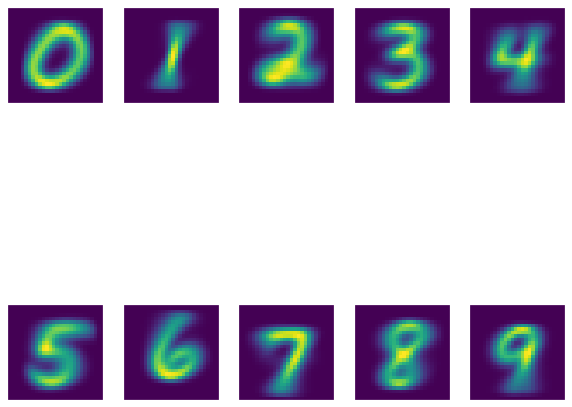

In [3]:
labels = []

for i in range(10):
    label = np.where(y == i)[0]
    labels.append(label)

fig, axes = plt.subplots(2,5,figsize = (10,10),subplot_kw = dict(xticks=[],yticks=[]))

for i,ax in enumerate(axes.flat):
    ax.imshow(np.mean(X[labels[i],:,:].reshape(len(labels[i]),784), axis = 0).reshape(28,28), cmap = 'viridis')
    

In [70]:
#df_train = pd.concat([pd.DataFrame(X.reshape(60000, 784)), pd.DataFrame(y, columns=['y'] )], axis = 1)
#df_train.head()
#df_train.info()
corrs = []
for i in range(10):
    lab = np.where(y == i)[0]
    #plt.imshow(df_train.iloc[lab[0],:784].values.reshape(28,28), cmap = 'viridis')
    #plt.axis('off')
    corrs.append(df_train.iloc[lab,:784].corr())

# something's wrong here, producing NaNs

## Gaussian Mixture with 10 components

In [20]:
from sklearn.mixture import GaussianMixture

model = GaussianMixture(10, covariance_type = 'full', random_state = 42)

model.fit(X.reshape(60000,784))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

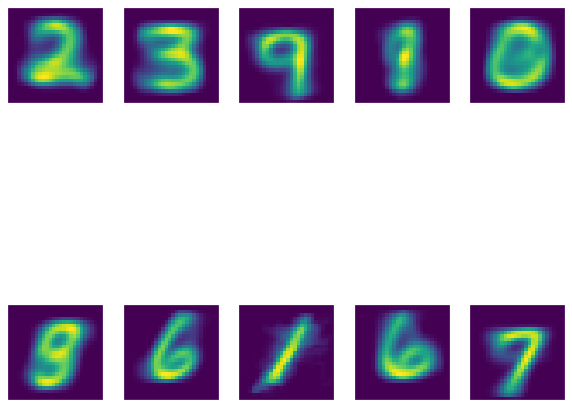

In [22]:
fig, axes = plt.subplots(2,5, figsize = (10,10),subplot_kw = dict(xticks=[],yticks=[]) )

for i,ax in enumerate(axes.flat):
    ax.imshow(model.means_[i,:].reshape(28,28), cmap = 'viridis')

These are quite different than expected. 

## Covariance Matrices 

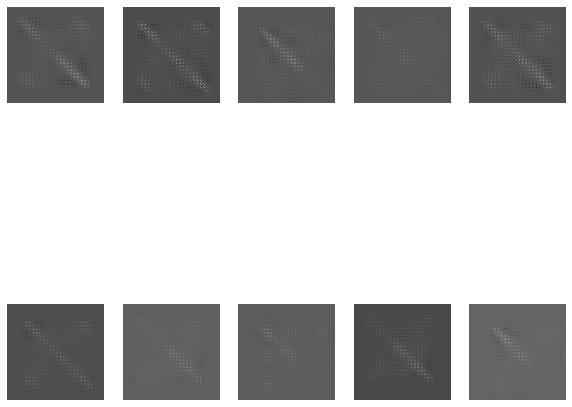

In [77]:
fig, axes = plt.subplots(2,5, figsize = (10,10), subplot_kw = dict(xticks=[], yticks=[]))

for i,ax in enumerate(axes.flat):
    ax.imshow(model.covariances_[i,:,:], cmap = 'gray')
    ax.axis('off')

#plt.imshow(model.covariances_[0,:,:], cmap = 'viridis')
#plt.axis('off')

## Sample Generation

In [93]:
def plot_digit(dataset):
    fig,axes = plt.subplots(10,10, figsize=(12,12),subplot_kw = dict(xticks=[],yticks=[]))
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(dataset[i,:,:], cmap = 'binary')
        

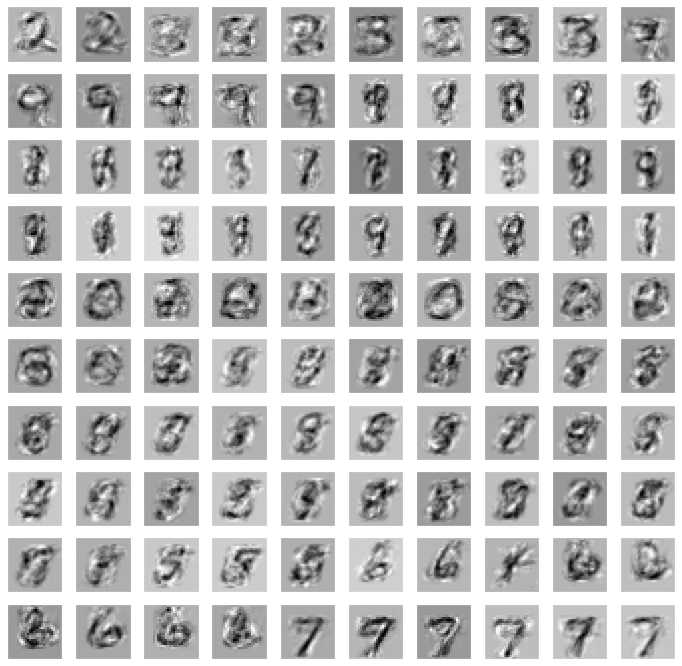

In [80]:
generated_data = model.sample(100)

plot_digit(generated_data[0].reshape(100,28,28))

Samples from the 10 component Gaussians aren't quite impressive.

In [87]:
model_100 = GaussianMixture(100, covariance_type = 'full', random_state = 42)

model_100.fit(X[:10000,:,:].reshape(10000,784))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=100, n_init=1, precisions_init=None,
        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

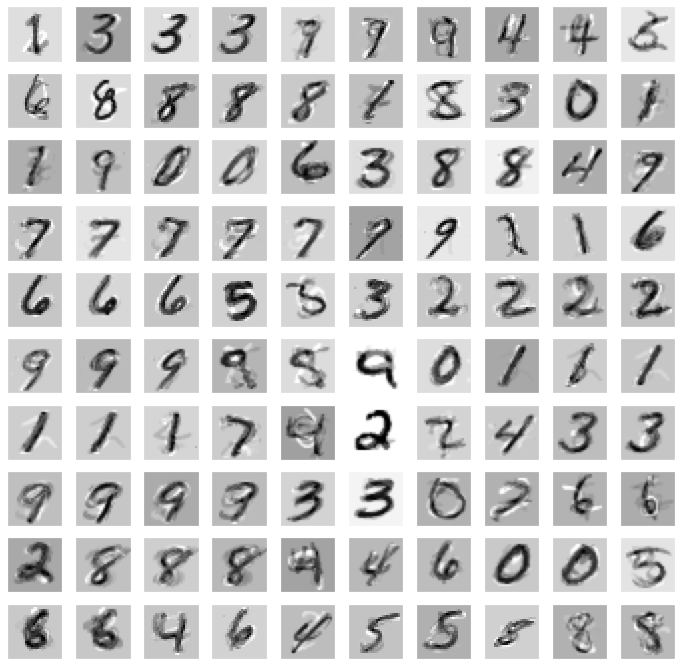

In [85]:
# n_component = 100
# training samples = 1000
generated_data = model_100.sample(100)

plot_digit(generated_data[0].reshape(100,28,28))

100 component Gaussian Mixture trained with only 1000 samples giving much better samples. while it expected that more the components, the estimated distribution would  be better estimated, however, the fact that only 1000 samples have been able to give good generated samples, is important. 

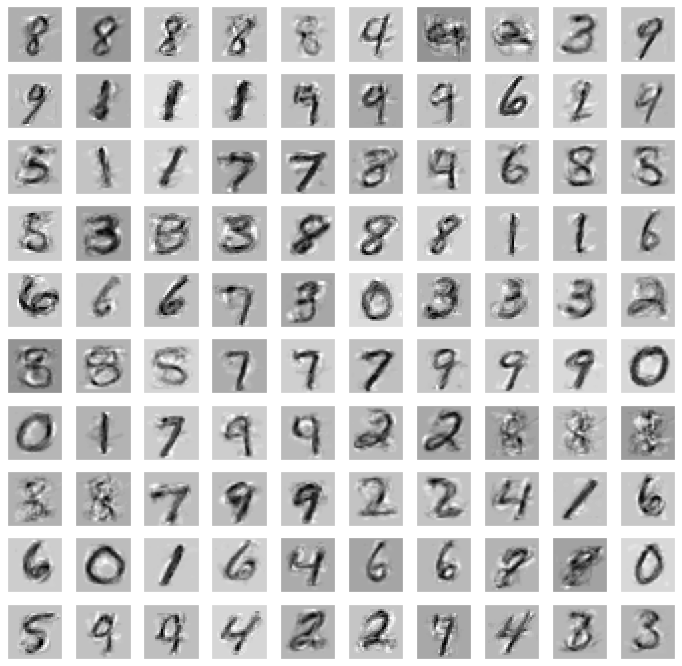

In [88]:
# n_component = 100
# training samples = 10000
generated_data = model_100.sample(100)

plot_digit(generated_data[0].reshape(100,28,28))

Let's see what could be optimal number of clusters

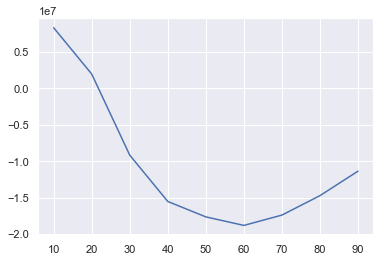

In [91]:
n_components = np.arange(10,100,10)
models = [GaussianMixture(n, covariance_type = 'full', random_state = 0)
         for n in n_components]
aics = [model.fit(X[:10000,:,:].reshape(10000,784)).aic(X[:10000,:,:].reshape(10000,784)) for model in models]
plt.plot(n_components, aics)

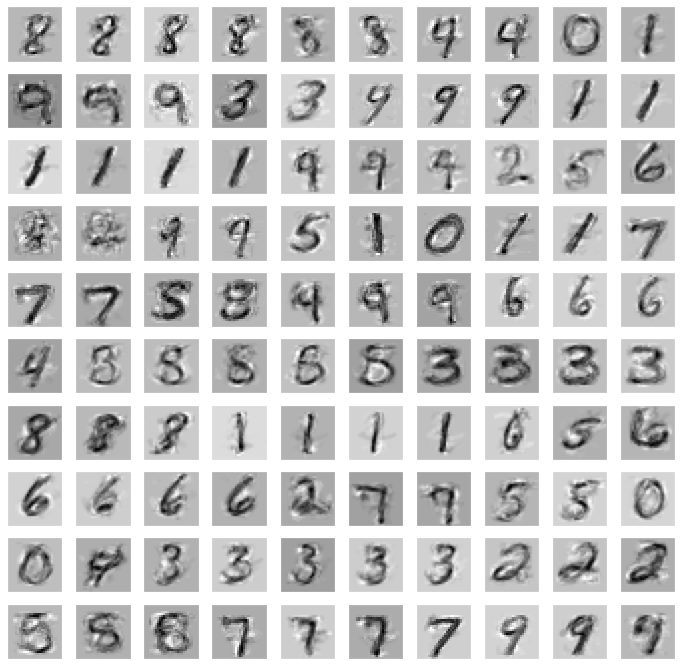

In [92]:
model = GaussianMixture(60, covariance_type = 'full', random_state = 42)
model.fit(X[:10000,:,:].reshape(10000,784))

generated_data = model.sample(100)
plot_digit(generated_data[0].reshape(100,28,28))

AIC gives us a way to find the optimal number of components to consider while clustering, it, however, shouldn't be the case with density estimation. i.e. since we are estimating the density of the digits, the optimal no. of clusters has nothing to do with the quality of the generated samples. \
In fact we can see that the samples generated from the this optimal number of clusters aren't better than what we have got using 100 components. Maybe we will get even better samples using more components.

Next we consider a 10 commoponent mixture model, a component each for each digits, where the components are 100-componenet Gaussian Mixtures 

## 10 component Mixture with each component being a 100 component Gaussian

In [8]:
#labels

labels_reduced = []

for i in range(len(labels)):
    labels_reduced.append(np.random.choice(labels[i], 200, replace = False))

#labels_reduced

In [9]:
from sklearn.mixture import GaussianMixture as gmm

models = []

for i in range(10):
    model = gmm(100, covariance_type = 'full', random_state = 0)
    model.fit(X[labels_reduced[i],:,:].reshape(200, 784))
    models.append(model)


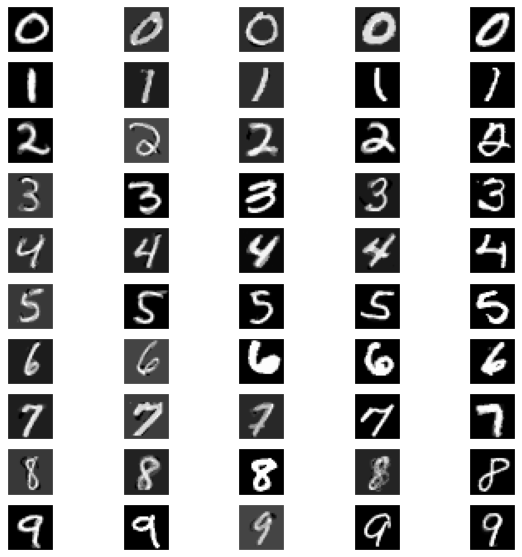

In [24]:
generated_data = []

for mod in models:
    generated_data.extend(mod.sample(5)[0])

fig, axes = plt.subplots(10,5, figsize = (10,10), subplot_kw = dict(xticks=[], yticks= []))

for i,ax in enumerate(axes.flat):
    ax.imshow(generated_data[i].reshape(28,28), cmap = 'gray')
    

These are really great. All of the samples are realistic. This level of performance was achieved only with 20k samples, a third of the whole training data available.\
However, really no idea why the colour flipped.

Don't know wehether a 1000 component Gaussian trained on the whole data would be better or not